In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import cm
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
from scipy.spatial import KDTree
import networkx as nx


from src.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

In [16]:
he_image_dir = "/projectbig/jupyternotebook/xenium_cgn/results_behnam/registered_HE_LEVEL1/"

In [3]:
adata = sc.read_h5ad("adata/adata_nichepca_with_domain_tuned_v1.h5ad")
sample_set = adata.obs['sample'].unique()
sample_set

In [29]:
sample = 'X35'

In [30]:
adata_i = adata[adata.obs['sample'] == sample]
he_image = plt.imread(he_image_dir + f'{sample}.tiff')

In [31]:
slide_id = adata_i.obs['Slide_ID'][0]
adata_i.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
adata_i.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1

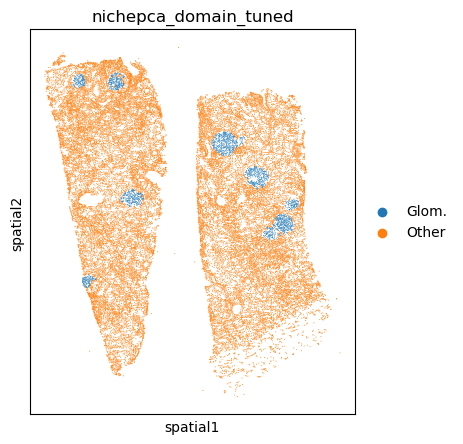

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.spatial(adata_i,
              library_id = slide_id,
              img_key = 'he_downscaled_aligned',
              color = 'nichepca_domain_tuned',
              size = .2,
              ax = ax,
              show = True)

## Plot only gloms in jpg format

In [6]:
# he_image_dir = "/projectbig/jupyternotebook/xenium_cgn/registered_HE_LEVEL1/"
# adata_dir = "/projectbig/jupyternotebook/xenium_cgn/robin_xenium_cgn_from_epyc/seperate_samples/adata_LEVEL1_new/"
# adata_save_dir = "/projectbig/jupyternotebook/xenium_cgn/adata_registered_HE_LEVEL1/"

he_image_dir = "/projectbig/jupyternotebook/xenium_cgn/results_behnam/registered_HE_LEVEL1/"
adata_dir = "/projectbig/jupyternotebook/xenium_cgn/results_behnam/adata_registered_HE_LEVEL1/"
adata_save_dir = "/projectbig/jupyternotebook/xenium_cgn/results_behnam/adata_registered_HE_LEVEL1/"

In [7]:
window = 100
dpi = 100

for sample in tqdm(sample_set):    

    if int(sample) == 7:
        continue
    
    adata_i = sc.read(adata_dir + f'X{sample}.h5ad')
    he_image = plt.imread(he_image_dir + f'X{sample}.tiff')
    slide_id = list(adata_i.uns['spatial'].keys())[0]
    adata_i.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
    adata_i.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1

    adata_i_nichpca = adata[adata.obs['Sample_num'] == f'X{sample}']
    adata_i.obs['nichepca_glom_no'] = adata_i_nichpca.obs['nichepca_glom_no']

    adata_i.write(adata_save_dir + f'X{sample}.h5ad')
    
    glom_no = adata_i.obs['nichepca_glom_no'].unique()
    for i in glom_no:
        if i != 'Other':
            x, y = adata_i.obs.loc[adata_i.obs['nichepca_glom_no'] == i, ['x', 'y']].mean()

            x_min = x - window
            x_max = x + window
            y_min = y - window
            y_max = y + window

            fig, ax = plt.subplots(figsize=(5, 5))
            sc.pl.spatial(adata_i[(adata_i.obs['x'] > x_min) & (adata_i.obs['x'] < x_max) & (adata_i.obs['y'] > y_min) & (adata_i.obs['y'] < y_max)],
                          library_id=slide_id,
                          img_key='he_downscaled_aligned',
                          ax=ax,
                          show=False)
            
            # Set aspext ratio, remove the box and text
            plt.gca().set_aspect('equal', adjustable='box')
            plt.xlabel('')
            plt.ylabel('')
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            
            plt.savefig(f"glom_single_dpi{dpi}_smaller_window/sample_X{sample}_glom_{i}.jpg", format='jpg', bbox_inches='tight', dpi=dpi)
            # plt.show
            plt.close(fig)

100%|██████████| 60/60 [1:13:55<00:00, 73.92s/it] 


## Plot glom with gene for a set of selected gloms

In [120]:
set1 = ['10_0011762_Cntrl_X1',
 '5_0011762_Cntrl_X2',
 '24_0011762_Cntrl_X1',
 '4_0011762_Cntrl_X1',
 '14_0011762_Cntrl_X1',
 '19_0011762_Cntrl_X1',
 '9_0011762_Cntrl_X2',
 '8_0011762_Cntrl_X2',
 '16_0011762_Cntrl_X1',
 '18_0011762_Cntrl_X1']

set2 = ['13_0011762_Cntrl_X1',
 # '2_0011762_Sle_X7',
 '11_0011762_Cntrl_X1',
 '2_0011762_Cntrl_X1',
 '31_0011762_Cntrl_X1',
 '21_0011762_Cntrl_X1',
 '8_0011762_Cntrl_X1',
 '0_0011762_Anca_X6',
 '12_0011762_Cntrl_X1']

set3 = ['26_0011762_Cntrl_X1',
 '7_0011762_Anca_X3',
 '8_0011762_Anca_X3',
 '4_0011762_Anca_X4',
 '3_0011762_Anca_X3',
 '2_0011762_Anca_X3',
 '5_0011762_Anca_X3',
 '1_0011762_Anca_X3',
 '0_0011762_Gbm_X5']


set = set1 + set2 + set3

genes = ['NPHS2', 'PODXL', 'IL17A', 'CD4', 'CD8', 'CD68',
         'TRGC1', 'TRGC2', 'TRDC', 'TRDV2', 'TRGV9']

window = 250
dpi = 300

  0%|          | 0/3 [00:00<?, ?it/s]

gene CD8 not exist for sample X14
gene CD68 not exist for sample X14


 33%|███▎      | 1/3 [00:14<00:29, 14.51s/it]

gene TRDV2 not exist for sample X14
gene TRGV9 not exist for sample X14
gene CD8 not exist for sample X36
gene CD68 not exist for sample X36


 67%|██████▋   | 2/3 [00:26<00:13, 13.25s/it]

gene TRDV2 not exist for sample X36
gene TRGV9 not exist for sample X36
gene CD8 not exist for sample X36
gene CD68 not exist for sample X36


100%|██████████| 3/3 [00:40<00:00, 13.42s/it]

gene TRDV2 not exist for sample X36
gene TRGV9 not exist for sample X36


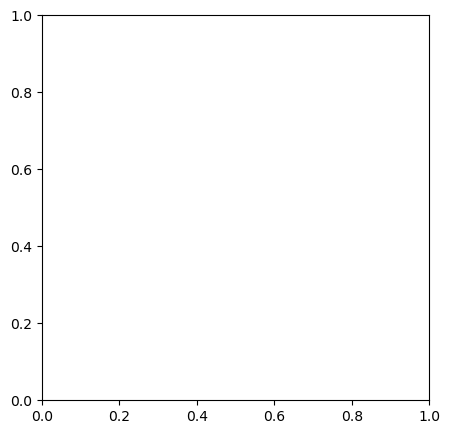

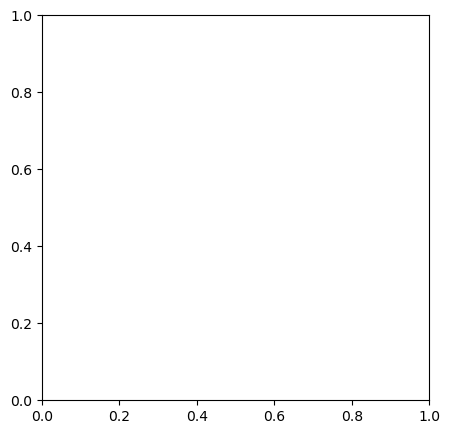

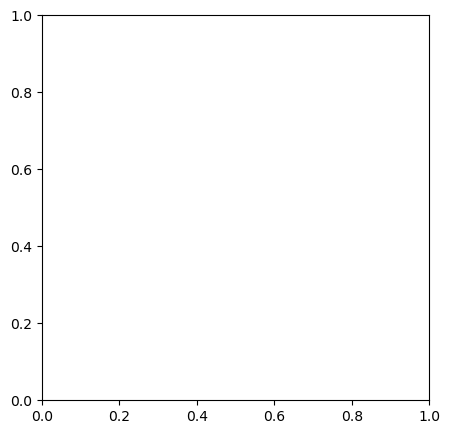

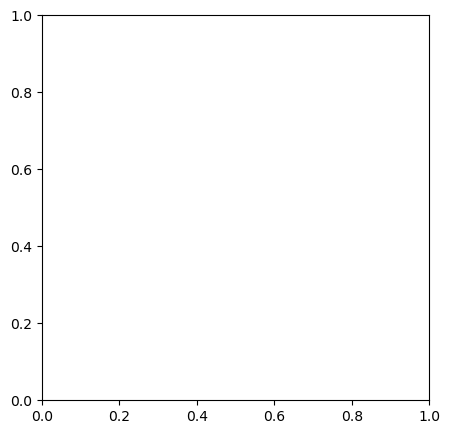

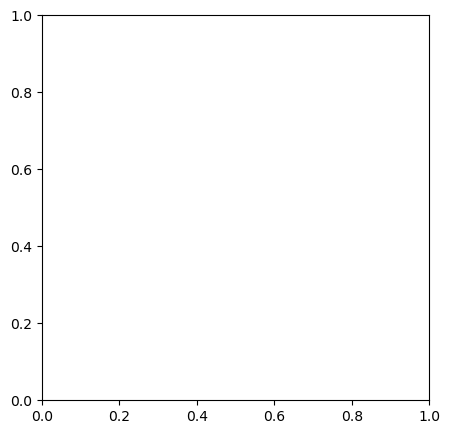

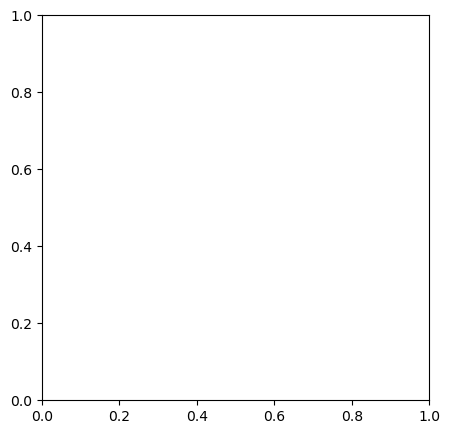

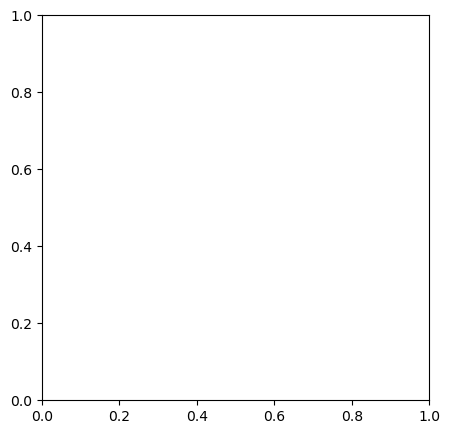

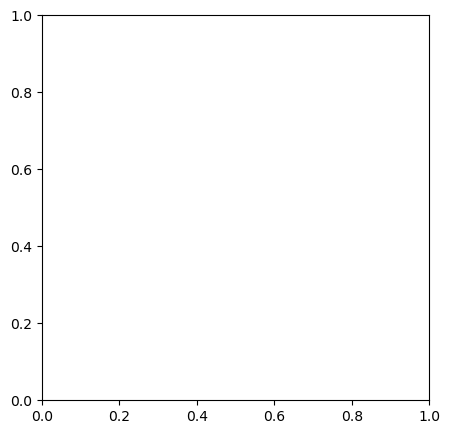

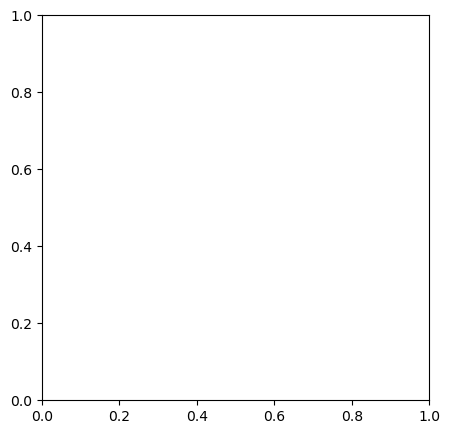

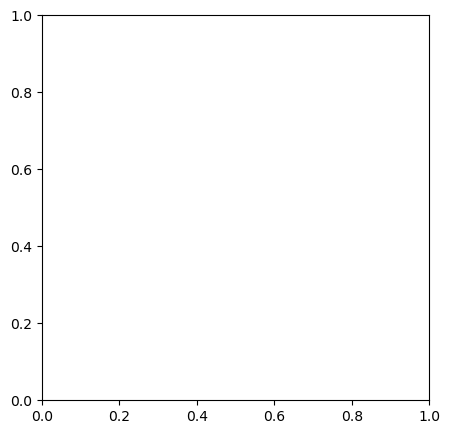

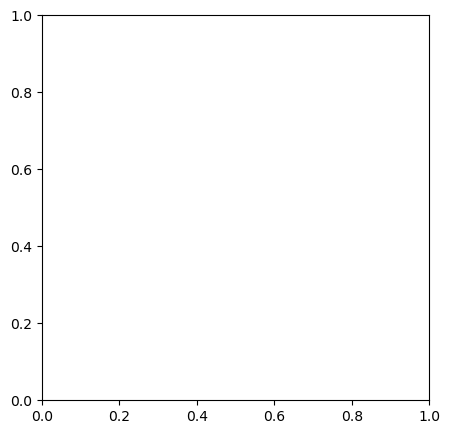

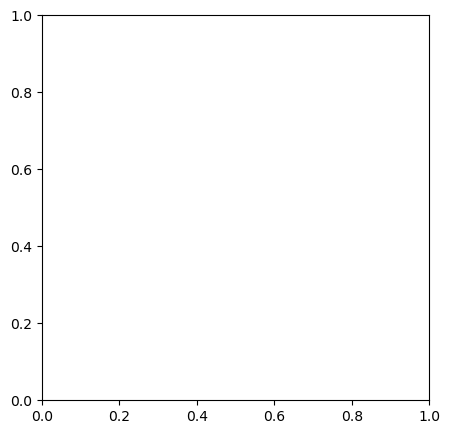

In [121]:
set = ['1_0011546_Anca_X14', '0_0011695_Anca_X36', '6_0011695_Anca_X36']

for glom in tqdm(set):

    tmp = glom.split("_")
    sample = tmp[3]
    i = tmp[0]     # glom number

    # adata_i = sc.read(adata_save_dir + f'{sample}.h5ad')


    adata_i = sc.read(adata_dir + f'{sample}.h5ad')
    he_image = plt.imread(he_image_dir + f'{sample}.tiff')
    slide_id = list(adata_i.uns['spatial'].keys())[0]
    adata_i.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
    adata_i.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1

    adata_i_nichpca = adata[adata.obs['Sample_num'] == f'{sample}']
    adata_i.obs['nichepca_glom_no'] = adata_i_nichpca.obs['nichepca_glom_no']

    
    
    x, y = adata_i.obs.loc[adata_i.obs['nichepca_glom_no'] == i, ['x', 'y']].mean()

    x_min = x - 130 # window
    x_max = x + 100 # window
    y_min = y - 230 # window
    y_max = y + 200 # window

    x_min = x - window
    x_max = x + window
    y_min = y - window
    y_max = y + window
    
    for gene in genes:
        fig, ax = plt.subplots(figsize=(5, 5))
        try:
            sc.pl.spatial(adata_i[(adata_i.obs['x'] > x_min) & (adata_i.obs['x'] < x_max) & (adata_i.obs['y'] > y_min) & (adata_i.obs['y'] < y_max)],
                          library_id=adata_i.obs['Slide_ID'][0],
                          img_key='he_downscaled_aligned',
                          color=gene,
                          size=.2,
                          ax=ax,
                          show=False)
            
            plt.savefig(f"gloms_selected_with_expression_new/sample_{sample}_glom_{i}_gene_{gene}.jpg", format='jpg', bbox_inches='tight', dpi=dpi)
        except:
            print(f'gene {gene} not exist for sample {sample}')
        plt.close()

## Plot glom with gDT for a set of selected gloms

In [112]:
set = ['X3_2']
set = ['1_0011546_Anca_X14', '0_0011695_Anca_X36', '6_0011695_Anca_X36']

In [118]:
# format: set = sample_glom
dpi = 300
window = 250

for glom in tqdm(set):

    tmp = glom.split("_")
    # sample = tmp[0]
    # i = tmp[1]     # glom number

    sample = tmp[3]
    i = tmp[0]     # glom number
    
    # adata_i = sc.read(adata_save_dir + f'{sample}.h5ad')


    adata_i = sc.read(adata_dir + f'{sample}.h5ad')
    he_image = plt.imread(he_image_dir + f'{sample}.tiff')
    slide_id = list(adata_i.uns['spatial'].keys())[0]
    adata_i.uns['spatial'][slide_id]['images']['he_downscaled_aligned'] = he_image  
    adata_i.uns['spatial'][slide_id]['scalefactors']['tissue_he_downscaled_aligned_scalef'] = 1

    adata_i_nichpca = adata[adata.obs['Sample_num'] == f'{sample}']
    adata_i.obs['nichepca_glom_no'] = adata_i_nichpca.obs['nichepca_glom_no']
    adata_i.obs['celltype_subsets'] = adata_i_nichpca.obs['celltype_subsets']
    
    x, y = adata_i.obs.loc[adata_i.obs['nichepca_glom_no'] == i, ['x', 'y']].mean()

    x_min = x - 130 # window
    x_max = x + 100 # window
    y_min = y - 230 # window
    y_max = y + 200 # window

    x_min = x - window
    x_max = x + window
    y_min = y - window
    y_max = y + window

    adata_i.obs['is_gdT'] = [1 if i == 'gdT' else None for i in adata_i.obs['celltype_subsets']]

    # print(f"sample_{sample}_glom_{i} adata_i.obs['is_gdT'].sum())
    
    # try:
    fig, ax = plt.subplots(figsize=(5, 5))
    sc.pl.spatial(adata_i[(adata_i.obs['x'] > x_min) & (adata_i.obs['x'] < x_max) & (adata_i.obs['y'] > y_min) & (adata_i.obs['y'] < y_max)],
                  library_id=adata_i.obs['Slide_ID'][0],
                  img_key='he_downscaled_aligned',
                  color='is_gdT',
                  size=.2,
                  ax=ax,
                  show=False)
    
    plt.savefig(f"gloms_selected_gDT_new/sample_{sample}_glom_{i}.jpg", format='jpg', bbox_inches='tight', dpi=dpi)
    plt.close()
    # except:
        # print(f'gene {gene} not exist for sample {sample}')

100%|██████████| 3/3 [00:20<00:00,  6.81s/it]


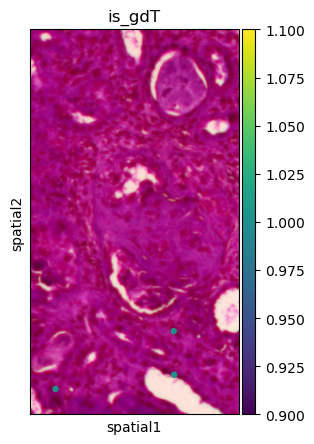

In [117]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.spatial(adata_i[(adata_i.obs['x'] > x_min) & (adata_i.obs['x'] < x_max) & (adata_i.obs['y'] > y_min) & (adata_i.obs['y'] < y_max)],
              library_id=adata_i.obs['Slide_ID'][0],
              img_key='he_downscaled_aligned',
              color='is_gdT',
              size=.2,
              ax=ax,
              show=True)

## Count the number of gDT cell per all gloms

In [35]:
adata = sc.read_h5ad("/projectbig/jupyternotebook/xenium_cgn/results_behnam/adata_repo/data_glom_ann_cell_type_v1.h5ad")

In [101]:
df = pd.DataFrame(columns=['sample', 'glom', 'disease', 'no_gdt', 'no_total', 'gdt_ratio'])

for sample in tqdm(sample_set):

    adata_i = adata[adata.obs['Sample_num'] == f'X{sample}']
    
    # adata_i.obs['is_gdT'] = [1 if i == 'gdT' else 0 for i in adata_i.obs['celltype_subsets']]
    # adata_i.obs['is_gdT'] = np.where(adata_i.obs['celltype_subsets'] == 'gdT', 1, 0)

    mapping = {'gdT': 1}
    adata_i.obs['is_gdT'] = adata_i.obs['celltype_subsets'].map(mapping).fillna(0).astype(int)

    disease = adata_i.obs['Disease'][0]

    # glom_key = 'nichepca_glom_no'
    glom_key = 'glom_ID'
    glom_no = adata_i.obs[glom_key].unique()
    for i in glom_no:
        if i.split("_")[0] != 'Other':
            g = adata_i.obs.loc[adata_i.obs[glom_key] == i, 'is_gdT'].sum()
            pg = adata_i.obs.loc[adata_i.obs['polygon_flags'] == i, 'is_gdT'].sum()
            no_gdt = g + pg
            no_total = len(adata_i.obs.loc[adata_i.obs[glom_key] == i, 'is_gdT'])
            df.loc[len(df)] = [sample, i, disease, no_gdt, no_total, no_gdt/no_total]

100%|██████████| 60/60 [35:42<00:00, 35.70s/it] 


In [102]:
# df.to_csv("/projectbig/jupyternotebook/xenium_cgn/gDT_all_gloms.csv")
df.to_csv("gDT_all_gloms_pregloms.csv")

In [106]:
df.loc[df['no_gdt'] > 1]

sample                 glom disease  no_gdt  no_total  gdt_ratio
26       1  26_0011762_Cntrl_X1   Cntrl       3       124   0.024194
47       3    2_0011762_Anca_X3    Anca       2       174   0.011494
87       9  11_0011546_Cntrl_X9   Cntrl       2       139   0.014388
175     13    3_0011546_Gbm_X13     Gbm       2       640   0.003125
182     13   10_0011546_Gbm_X13     Gbm       3        89   0.033708
185     14   0_0011546_Anca_X14    Anca       2       154   0.012987
186     14   1_0011546_Anca_X14    Anca       6       654   0.009174
192     14   7_0011546_Anca_X14    Anca       2       216   0.009259
195     15    0_0011546_Sle_X15     Sle       2       321   0.006231
233     17  12_0011216_Anca_X17    Anca       2       204   0.009804
249     19   2_0011216_Anca_X19    Anca       2       665   0.003008
257     21    0_0011216_Gbm_X21     Gbm       2      1003   0.001994
260     21    3_0011216_Gbm_X21     Gbm       2       975   0.002051
263     21    6_0011216_Gbm_X21     Gbm       4       665   0.006015
264     21    7_0011216_Gbm_X21     Gbm       2       620   0.003226
269     21   12_0011216_Gbm_X21     Gbm       3       655   0.004580
350     27   3_0011707_Anca_X27    Anca       2       254   0.007874
354     27   7_0011707_Anca_X27    Anca       2       523   0.003824
359     27  12_0011707_Anca_X27    Anca       2       189   0.010582
362     27  15_0011707_Anca_X27    Anca       2       333   0.006006
415     30   14_0011707_Sle_X30     Sle       2       110   0.018182
417     31    1_0011707_Sle_X31     Sle       4       442   0.009050
435     31   19_0011707_Sle_X31     Sle       2       171   0.011696
453     33   4_0011695_Anca_X33    Anca       3       166   0.018072
475     36   0_0011695_Anca_X36    Anca       6       686   0.008746
477     36   2_0011695_Anca_X36    Anca       4       231   0.017316
479     36   4_0011695_Anca_X36    Anca       2       216   0.009259
481     36   6_0011695_Anca_X36    Anca       6       581   0.010327
483     36   8_0011695_Anca_X36    Anca       2       249   0.008032
485     36  10_0011695_Anca_X36    Anca       3       267   0.011236
490     37   3_0011695_Anca_X37    Anca       2        65   0.030769
509     38    2_0011695_Gbm_X38     Gbm       2       285   0.007018
587     43   6_0011284_Anca_X43    Anca       2       132   0.015152
590     44   2_0011284_Anca_X44    Anca       2       139   0.014388
592     44   4_0011284_Anca_X44    Anca       3        73   0.041096
649     49  19_0011287_Anca_X49    Anca       2        41   0.048780
682     53   5_0011287_Anca_X53    Anca       2       597   0.003350
684     53   7_0011287_Anca_X53    Anca       2       230   0.008696
691     53  14_0011287_Anca_X53    Anca       3       332   0.009036
693     53  16_0011287_Anca_X53    Anca       3       190   0.015789
806     58   1_0018775_Anca_X58    Anca       2       200   0.010000
808     58   3_0018775_Anca_X58    Anca       2       176   0.011364
812     58   7_0018775_Anca_X58    Anca       2       136   0.014706
827     60  10_0018775_Anca_X60    Anca       2        30   0.066667
838     63   0_0018775_Anca_X63    Anca       4      2326   0.001720
842     63   4_0018775_Anca_X63    Anca       3      1682   0.001784
843     63   5_0018775_Anca_X63    Anca       4       549   0.007286
854     63  16_0018775_Anca_X63    Anca       2       528   0.003788

In [7]:
## Single samples, with tunable window

In [33]:
sample = 'X6'
i = '0'     # glom number

adata_i = adata[adata.obs['Sample_num'] == sample]
x, y = adata_i.obs.loc[adata_i.obs['nichepca_glom_no'] == i, ['x', 'y']].mean()

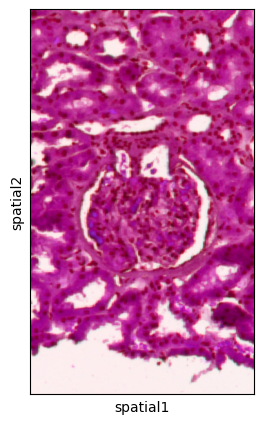

In [34]:
x_min = x - 130
x_max = x + 100
y_min = y - 230
y_max = y + 200

fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.spatial(adata_i[(adata_i.obs['x'] > x_min) & (adata_i.obs['x'] < x_max) & (adata_i.obs['y'] > y_min) & (adata_i.obs['y'] < y_max)],
              library_id=adata_i.obs['Slide_ID'][0],
              img_key='he_downscaled_aligned',
              ax=ax,
              show=True)
plt.show()

gene CD8 not exist for sample X6
gene CD68 not exist for sample X6
Done!


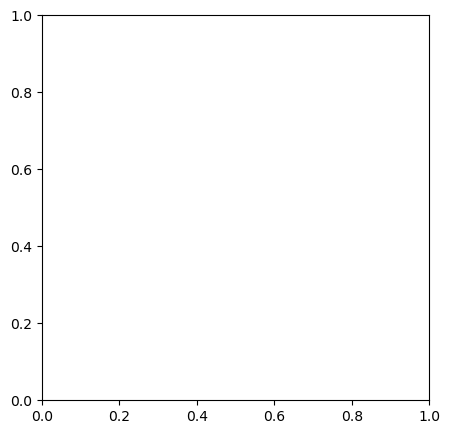

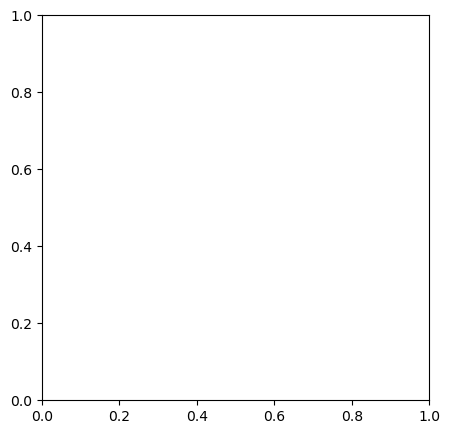

In [35]:
for gene in genes:
    try:
        fig, ax = plt.subplots(figsize=(5, 5))
        sc.pl.spatial(adata_i[(adata_i.obs['x'] > x_min) & (adata_i.obs['x'] < x_max) & (adata_i.obs['y'] > y_min) & (adata_i.obs['y'] < y_max)],
                      library_id=adata_i.obs['Slide_ID'][0],
                      img_key='he_downscaled_aligned',
                      color=gene,
                      size=.2,
                      ax=ax,
                      show=False)
        
        plt.savefig(f"gloms_selected_with_expression/SELECTED_sample_{sample}_glom_{i}_gene_{gene}.jpg", format='jpg', bbox_inches='tight', dpi=dpi)
        plt.close()
    except:
        print(f'gene {gene} not exist for sample {sample}')

print("Done!")

In [ ]:
# X2_5
x_min = x - 150
x_max = x + 100
y_min = y - 250
y_max = y + 200

# X3_1
x_min = x - 130
x_max = x + 100
y_min = y - 230
y_max = y + 200

# X3_2
x_min = x - 130
x_max = x + 100
y_min = y - 230
y_max = y + 200

# X6_0
x_min = x - 130
x_max = x + 100
y_min = y - 230
y_max = y + 200

In [9]:
adata.obs.columns

Index(['x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation',
       'area', 'avg_confidence', 'avg_assignment_confidence',
       'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area',
       'annot', 'annot_n', 'ID', 'Disease', 'Slide_num', 'Sample_num',
       'Slide_ID', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_proba',
       'batch', 'nichepca_ann', 'nichepca_glom_no', 'nichepca_clusters'],
      dtype='object')

In [10]:
adata2 = sc.read_h5ad("/projectbig/jupyternotebook/xenium_cgn/robin_xenium_cgn_from_epyc/h5ad_aligned/merged_with_Disease_ImmuneCellSubtypes.h5ad")

In [13]:
adata.obs['celltype_subsets'] = adata2.obs['celltype_subsets']

In [14]:
adata.write("/projectbig/jupyternotebook/xenium_cgn/adata_repo/data_glom_ann_cell_type_v1.h5ad")

In [6]:
adata = sc.read_h5ad("/projectbig/jupyternotebook/xenium_cgn/results_behnam/adata_repo/data_glom_ann_cell_type_v1.h5ad")

In [9]:
adata.obs['Disease']

cell_CRc5a3721c5-120227_0011546     Anca
cell_CR85333614e-227363_0011284     Anca
cell_CRe9244f5f0-274454_0018775     Anca
cell_CRd921aadf4-7960_0011216        Sle
cell_CR85333614e-19040_0011284       Sle
                                   ...  
cell_CRb53fa7cc5-166196_0011762     Anca
cell_CRb53fa7cc5-152995_0011762     Anca
cell_CRb53fa7cc5-208012_0011762    Cntrl
cell_CRb53fa7cc5-211260_0011762    Cntrl
cell_CRb53fa7cc5-22467_0011762      Anca
Name: Disease, Length: 2899179, dtype: category
Categories (4, object): ['Anca', 'Cntrl', 'Gbm', 'Sle']